In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
%pip install torch-summary matplotlib scipy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class BottleneckBlock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                )
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        identity = self.shortcut(identity)

        out += identity
        out = F.relu(out)
        return out


summary(BottleneckBlock(16, 32, 1), (16, 128, 128), verbose=0)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 128, 128]        4,608
├─BatchNorm2d: 1-2                       [-1, 32, 128, 128]        64
├─Conv2d: 1-3                            [-1, 32, 128, 128]        9,216
├─BatchNorm2d: 1-4                       [-1, 32, 128, 128]        64
├─Sequential: 1-5                        [-1, 32, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 32, 128, 128]        512
Total params: 14,464
Trainable params: 14,464
Non-trainable params: 0
Total mult-adds (M): 234.88
Input size (MB): 1.00
Forward/backward pass size (MB): 20.00
Params size (MB): 0.06
Estimated Total Size (MB): 21.06

In [2]:
from functools import reduce


class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(
                input_size[0], 64, kernel_size=7, stride=2, padding=3, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.residual_blocks = nn.Sequential(
            BottleneckBlock(64, 64),
            BottleneckBlock(64, 64),
            BottleneckBlock(64, 64),

            BottleneckBlock(64, 128, stride=2),
            BottleneckBlock(64, 128),
            BottleneckBlock(64, 128),
            BottleneckBlock(64, 128),

            BottleneckBlock(128, 256, stride=2),
            BottleneckBlock(128, 256),
            BottleneckBlock(128, 256),
            BottleneckBlock(128, 256),
            BottleneckBlock(128, 256),
            BottleneckBlock(128, 256),

            BottleneckBlock(256, 512, stride=2),
            BottleneckBlock(256, 512),
            BottleneckBlock(256, 512),
        )

        self.input_size_to_fc = (
            summary(
                nn.Sequential(self.conv, self.residual_blocks), input_size, verbose=0
            )
            .summary_list[-1]
            .output_size[1:]
        )
        self.inputs_to_fc = reduce(lambda x, y: x * y, self.input_size_to_fc)

        self.fc_mu = nn.Linear(self.inputs_to_fc, latent_dim)
        self.fc_log_var = nn.Linear(self.inputs_to_fc, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.residual_blocks(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var


encoder = Encoder((1, 128, 128), 128)
summary(encoder, verbose=0)


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─BasicBlock: 2-5                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-6                   --
|    |    └─Conv2d: 3-6                  73,728
|    |    └─BatchNorm2d: 3-7             256
|    |    └─Conv2d: 3-8                  147,456
|    |    └─BatchNorm2d: 3-9             256
|    |    └─Sequential: 3-10             8,192
|    └─BasicBlock: 2-7                   --
|    |    └─Conv2d: 3-11                 294,912
|    |    └─BatchNorm2d: 3-12         

In [3]:
class ReverseBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ReverseBasicBlock, self).__init__()

        self.conv1 = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            output_padding=stride - 1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.ConvTranspose2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    output_padding=stride - 1,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        identity = self.shortcut(identity)

        out += identity
        out = F.relu(out)
        return out


summary(ReverseBasicBlock(512, 256, 1), (512, 7, 7), verbose=0)


Layer (type:depth-idx)                   Output Shape              Param #
├─ConvTranspose2d: 1-1                   [-1, 256, 7, 7]           1,179,648
├─BatchNorm2d: 1-2                       [-1, 256, 7, 7]           512
├─ConvTranspose2d: 1-3                   [-1, 256, 7, 7]           589,824
├─BatchNorm2d: 1-4                       [-1, 256, 7, 7]           512
├─Sequential: 1-5                        [-1, 256, 7, 7]           --
|    └─ConvTranspose2d: 2-1              [-1, 256, 7, 7]           131,072
|    └─BatchNorm2d: 2-2                  [-1, 256, 7, 7]           512
Total params: 1,902,080
Trainable params: 1,902,080
Non-trainable params: 0
Total mult-adds (M): 93.26
Input size (MB): 0.10
Forward/backward pass size (MB): 0.57
Params size (MB): 7.26
Estimated Total Size (MB): 7.93

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, size_from_fc, out_channels):
        super(Decoder, self).__init__()

        self.size_from_fc = size_from_fc

        self.fc = nn.Linear(latent_dim, reduce(lambda x, y: x * y, size_from_fc))

        self.residual_blocks = nn.Sequential(
            ReverseBasicBlock(512, 256, stride=2),
            ReverseBasicBlock(256, 128, stride=2),
            ReverseBasicBlock(128, 64, stride=2),
            ReverseBasicBlock(64, 64, stride=2),
        )

        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                out_channels,
                kernel_size=7,
                stride=2,
                padding=3,
                output_padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(
            x.size(0), self.size_from_fc[0], self.size_from_fc[1], self.size_from_fc[2]
        )
        x = self.residual_blocks(x)
        x = self.conv_transpose(x)
        return x


decoder = Decoder(128, encoder.input_size_to_fc, 1)
summary(decoder, input_size=(128,), verbose=0)


Layer (type:depth-idx)                        Param #
├─Linear: 1-1                                 1,056,768
├─Sequential: 1-2                             --
|    └─ReverseBasicBlock: 2-1                 --
|    |    └─ConvTranspose2d: 3-1              1,179,648
|    |    └─BatchNorm2d: 3-2                  512
|    |    └─ConvTranspose2d: 3-3              589,824
|    |    └─BatchNorm2d: 3-4                  512
|    |    └─Sequential: 3-5                   131,584
|    └─ReverseBasicBlock: 2-2                 --
|    |    └─ConvTranspose2d: 3-6              294,912
|    |    └─BatchNorm2d: 3-7                  256
|    |    └─ConvTranspose2d: 3-8              147,456
|    |    └─BatchNorm2d: 3-9                  256
|    |    └─Sequential: 3-10                  33,024
|    └─ReverseBasicBlock: 2-3                 --
|    |    └─ConvTranspose2d: 3-11             73,728
|    |    └─BatchNorm2d: 3-12                 128
|    |    └─ConvTranspose2d: 3-13             36,864
|    |    └─B

In [5]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(VAE, self).__init__()

        self.input_size = input_size
        self.latent_dim = latent_dim

        self.encoder = Encoder(input_size, latent_dim)
        self.decoder = Decoder(latent_dim, self.encoder.input_size_to_fc, input_size[0])

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var


vae = VAE((1, 128, 128), 128)
summary(vae, input_size=vae.input_size, verbose=0)


Layer (type:depth-idx)                        Param #
├─Encoder: 1-1                                --
|    └─Sequential: 2-1                        --
|    |    └─Conv2d: 3-1                       3,136
|    |    └─BatchNorm2d: 3-2                  128
|    |    └─ReLU: 3-3                         --
|    |    └─MaxPool2d: 3-4                    --
|    └─Sequential: 2-2                        --
|    |    └─BasicBlock: 3-5                   73,984
|    |    └─BasicBlock: 3-6                   229,888
|    |    └─BasicBlock: 3-7                   918,528
|    |    └─BasicBlock: 3-8                   3,672,064
|    └─Linear: 2-3                            1,048,704
|    └─Linear: 2-4                            1,048,704
├─Decoder: 1-2                                --
|    └─Linear: 2-5                            1,056,768
|    └─Sequential: 2-6                        --
|    |    └─ReverseBasicBlock: 3-9            1,902,080
|    |    └─ReverseBasicBlock: 3-10           475,904
|    |

In [6]:
def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction="mean")
    kld_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss, kld_loss, recon_loss + beta * kld_loss


In [8]:
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

dataset_name = "cxr8"

base_data_path = Path("D:\\") / "data"

imagenet_data_path = (
    base_data_path
    / "imagenet-object-localization-challenge"
    / "ILSVRC"
    / "Data"
    / "CLS-LOC"
)

cxr8_data_path = base_data_path / "cxr8"


if dataset_name == "cxr8":
    train_dataset = datasets.ImageFolder(
        cxr8_data_path,
        transform=transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.Grayscale(),
                transforms.RandomEqualize(1.0),
                transforms.ToTensor(),
            ]
        ),
    )
elif dataset_name == "cifar10":
    train_dataset = datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((224, 224)), transforms.ToTensor()]
        ),
    )
elif dataset_name == "imagenet":
    train_dataset = datasets.ImageFolder(
        imagenet_data_path,
        transform=transforms.Compose(
            [transforms.Resize((224, 224)), transforms.ToTensor()]
        ),
    )

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

latent_dim = 128
model = VAE((1 if dataset_name == "cxr8" else 3, 224, 224), latent_dim).to(device)

import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)


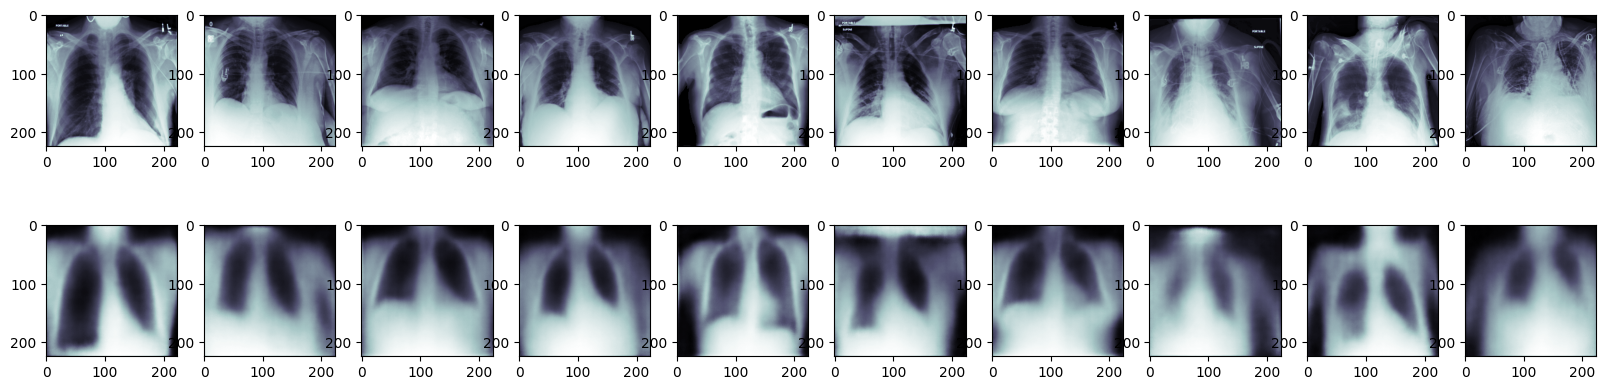

Epoch [3/10], Batch: 170, Loss: 0.5187 (0.5106/0.5375)
Epoch [3/10], Batch: 171, Loss: 0.5187 (0.5146/0.5172)
Epoch [3/10], Batch: 172, Loss: 0.5187 (0.5130/0.5154)
Epoch [3/10], Batch: 173, Loss: 0.5187 (0.5153/0.5301)
Epoch [3/10], Batch: 174, Loss: 0.5187 (0.5086/0.5414)
Epoch [3/10], Batch: 175, Loss: 0.5187 (0.5130/0.5156)
Epoch [3/10], Batch: 176, Loss: 0.5187 (0.5137/0.5322)
Epoch [3/10], Batch: 177, Loss: 0.5187 (0.5131/0.4944)
Epoch [3/10], Batch: 178, Loss: 0.5186 (0.5129/0.5063)
Epoch [3/10], Batch: 179, Loss: 0.5186 (0.5134/0.5373)


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

num_epochs = 10

fig, ax = plt.subplots(2, 10, figsize=(20,5))

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_count = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        recon_loss, kldiv_loss, loss = vae_loss(
            recon_batch, data, mu, log_var, beta=0.01
        )

        if train_count % 10 == 0:
            orig_data = data.clone().cpu().detach().numpy()
            recon_data = recon_batch.cpu().detach().numpy()

            # print(v.shape)
            for n in range(10):
                ax[0][n].imshow(torch.movedim(torch.tensor(orig_data[n]), 0, -1), cmap='bone')
                ax[1][n].imshow(torch.movedim(torch.tensor(recon_data[n]), 0, -1), cmap='bone')

            clear_output(wait=True)

            display(plt.gcf())

        loss.backward()
        train_loss += loss.item()
        train_count += 1.0
        optimizer.step()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Batch: {batch_idx}, Loss: {train_loss / train_count:.4f} ({recon_loss:.4f}/{kldiv_loss:.4f})"
        )        
        